In [21]:
# Import the inverse of the cumulative distribution function of the standard gaussian called ndtri
from scipy.special import ndtri
# Imported the norm library which can compute cdf of a standard gaussian
from scipy.stats import norm
# Necessary for finding values of r(Psi) for arbitrary Psi
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.integrate import quad

In [22]:
#pythran export LTInversion(float64, float64, float64, float64, float64, float64)

import numpy as np

def LTInversion(t,lamda,alpha,beta,gama,log_epsilon):
    # Evaluation of the relevant poles
    theta = np.angle(lamda)
    kmin = np.ceil(-alpha/2. - theta/2./np.pi)
    kmax = np.floor(alpha/2. - theta/2./np.pi)
    k_vett = np.arange(kmin, kmax+1)
    s_star = np.abs(lamda)**(1./alpha) * np.exp(1j*(theta+2*k_vett*np.pi)/alpha)

    # Evaluation of phi(s_star) for each pole
    phi_s_star = (np.real(s_star)+np.abs(s_star))/2

    # Sorting of the poles according to the value of phi(s_star)
    index_s_star = np.argsort(phi_s_star)
    phi_s_star = phi_s_star.take(index_s_star)
    s_star = s_star.take(index_s_star)

    # Deleting possible poles with phi_s_star=0
    index_save = phi_s_star > 1.0e-15
    s_star = s_star.repeat(index_save)
    phi_s_star = phi_s_star.repeat(index_save)

    # Inserting the origin in the set of the singularities
    s_star = np.hstack([[0], s_star])
    phi_s_star = np.hstack([[0], phi_s_star])
    J1 = len(s_star)
    J = J1 - 1

    # Strength of the singularities
    p = gama*np.ones((J1,), float)
    p[0] = max(0,-2*(alpha*gama-beta+1))
    q = gama*np.ones((J1,), float)
    q[-1] = np.inf
    phi_s_star = np.hstack([phi_s_star, [np.inf]])

    # Looking for the admissible regions with respect to round-off errors
    admissible_regions = \
       np.nonzero(np.bitwise_and(
           (phi_s_star[:-1] < (log_epsilon - np.log(np.finfo(np.float64).eps))/t),
           (phi_s_star[:-1] < phi_s_star[1:])))[0]
    # Initializing vectors for optimal parameters
    JJ1 = admissible_regions[-1]
    mu_vett = np.ones((JJ1+1,), float)*np.inf
    N_vett = np.ones((JJ1+1,), float)*np.inf
    h_vett = np.ones((JJ1+1,), float)*np.inf

    # Evaluation of parameters for inversion of LT in each admissible region
    find_region = False
    while not find_region:
        for j1 in admissible_regions:
            if j1 < J1-1:
                muj, hj, Nj = OptimalParam_RB(t, phi_s_star[j1], phi_s_star[j1+1], p[j1], q[j1], log_epsilon)
            else:
                muj, hj, Nj = OptimalParam_RU(t, phi_s_star[j1], p[j1], log_epsilon)
            mu_vett[j1] = muj
            h_vett[j1] = hj
            N_vett[j1] = Nj
        if N_vett.min() > 200:
            log_epsilon = log_epsilon + np.log(10)
        else:
            find_region = True

    # Selection of the admissible region for integration which
    # involves the minimum number of nodes
    iN = np.argmin(N_vett)
    N = N_vett[iN]
    mu = mu_vett[iN]
    h = h_vett[iN]

    # Evaluation of the inverse Laplace transform
    k = np.arange(-N, N+1)
    u = h*k
    z = mu*(1j*u+1.)**2
    zd = -2.*mu*u + 2j*mu
    zexp = np.exp(z*t)
    F = z**(alpha*gama-beta)/(z**alpha - lamda)**gama*zd
    S = zexp*F ;
    Integral = h*np.sum(S)/2./np.pi/1j

    # Evaluation of residues
    ss_star = s_star[iN+1:]
    Residues = np.sum(1./alpha*(ss_star)**(1-beta)*np.exp(t*ss_star))

    # Evaluation of the ML function
    E = Integral + Residues
    if np.imag(lamda) == 0.:
        E = np.real(E)
    return E

# =========================================================================
# Finding optimal parameters in a right-bounded region
# =========================================================================
def OptimalParam_RB(t, phi_s_star_j, phi_s_star_j1, pj, qj, log_epsilon):
    # Definition of some constants
    log_eps = -36.043653389117154 # log(eps)
    fac = 1.01
    conservative_error_analysis = False

    # Maximum value of fbar as the ration between tolerance and round-off unit
    f_max = np.exp(log_epsilon - log_eps)

    # Evaluation of the starting values for sq_phi_star_j and sq_phi_star_j1
    sq_phi_star_j = np.sqrt(phi_s_star_j)
    threshold = 2.*np.sqrt((log_epsilon - log_eps)/t)
    sq_phi_star_j1 = min(np.sqrt(phi_s_star_j1), threshold - sq_phi_star_j)

    # Zero or negative values of pj and qj
    if pj < 1.0e-14 and qj < 1.0e-14:
        sq_phibar_star_j = sq_phi_star_j
        sq_phibar_star_j1 = sq_phi_star_j1
        adm_region = 1

    # Zero or negative values of just pj
    if pj < 1.0e-14 and qj >= 1.0e-14:
        sq_phibar_star_j = sq_phi_star_j
        if sq_phi_star_j > 0:
            f_min = fac*(sq_phi_star_j/(sq_phi_star_j1-sq_phi_star_j))**qj
        else:
            f_min = fac
        if f_min < f_max:
            f_bar = f_min + f_min/f_max*(f_max-f_min)
            fq = f_bar**(-1/qj)
            sq_phibar_star_j1 = (2*sq_phi_star_j1-fq*sq_phi_star_j)/(2+fq)
            adm_region = True
        else:
            adm_region = False

    # Zero or negative values of just qj
    if pj >= 1.0e-14 and qj < 1.0e-14:
        sq_phibar_star_j1 = sq_phi_star_j1
        f_min = fac*(sq_phi_star_j1/(sq_phi_star_j1-sq_phi_star_j))**pj
        if f_min < f_max:
            f_bar = f_min + f_min/f_max*(f_max-f_min)
            fp = f_bar**(-1./pj)
            sq_phibar_star_j = (2.*sq_phi_star_j+fp*sq_phi_star_j1)/(2-fp)
            adm_region = True
        else:
            adm_region = False

    # Positive values of both pj and qj
    if pj >= 1.0e-14 and qj >= 1.0e-14:
        f_min = fac*(sq_phi_star_j+sq_phi_star_j1) / \
                (sq_phi_star_j1-sq_phi_star_j)**max(pj, qj)
        if f_min < f_max:
            f_min = max(f_min,1.5)
            f_bar = f_min + f_min/f_max*(f_max-f_min)
            fp = f_bar**(-1/pj)
            fq = f_bar**(-1/qj)
            if ~conservative_error_analysis:
                w = -phi_s_star_j1*t/log_epsilon
            else:
                w = -2.*phi_s_star_j1*t/(log_epsilon-phi_s_star_j1*t)
            den = 2+w - (1+w)*fp + fq
            sq_phibar_star_j = ((2+w+fq)*sq_phi_star_j + fp*sq_phi_star_j1)/den
            sq_phibar_star_j1 = (-(1.+w)*fq*sq_phi_star_j + (2.+w-(1.+w)*fp)*sq_phi_star_j1)/den
            adm_region = True
        else:
            adm_region = False

    if adm_region:
        log_epsilon = log_epsilon  - np.log(f_bar)
        if not conservative_error_analysis:
            w = -sq_phibar_star_j1**2*t/log_epsilon
        else:
            w = -2.*sq_phibar_star_j1**2*t/(log_epsilon-sq_phibar_star_j1**2*t)
        muj = (((1.+w)*sq_phibar_star_j + sq_phibar_star_j1)/(2.+w))**2
        hj = -2.*np.pi/log_epsilon*(sq_phibar_star_j1-sq_phibar_star_j) \
             / ((1.+w)*sq_phibar_star_j + sq_phibar_star_j1)
        Nj = np.ceil(np.sqrt(1-log_epsilon/t/muj)/hj)
    else:
        muj = 0.
        hj = 0.
        Nj = np.inf

    return muj, hj, Nj


# =========================================================================
# Finding optimal parameters in a right-unbounded region
# =========================================================================
def OptimalParam_RU(t, phi_s_star_j, pj, log_epsilon):
    # Evaluation of the starting values for sq_phi_star_j
    sq_phi_s_star_j = np.sqrt(phi_s_star_j)
    if phi_s_star_j > 0:
        phibar_star_j = phi_s_star_j*1.01
    else:
        phibar_star_j = 0.01
    sq_phibar_star_j = np.sqrt(phibar_star_j)

    # Definition of some constants
    f_min = 1
    f_max = 10
    f_tar = 5

    # Iterative process to look for fbar in [f_min,f_max]
    while True:
        phi_t = phibar_star_j*t
        log_eps_phi_t = log_epsilon/phi_t
        Nj = np.ceil(phi_t/np.pi*(1. - 3*log_eps_phi_t/2 + np.sqrt(1-2*log_eps_phi_t)))
        A = np.pi*Nj/phi_t
        sq_muj = sq_phibar_star_j*np.abs(4-A)/np.abs(7-np.sqrt(1+12*A))
        fbar = ((sq_phibar_star_j-sq_phi_s_star_j)/sq_muj)**(-pj)
        if (pj < 1.0e-14) or (f_min < fbar and fbar < f_max):
            break
        sq_phibar_star_j = f_tar**(-1./pj)*sq_muj + sq_phi_s_star_j
        phibar_star_j = sq_phibar_star_j**2
    muj = sq_muj**2
    hj = (-3*A - 2 + 2*np.sqrt(1+12*A))/(4-A)/Nj
    
    # Adjusting integration parameters to keep round-off errors under control
    log_eps = np.log(np.finfo(np.float64).eps)
    threshold = (log_epsilon - log_eps)/t
    if muj > threshold:
        if abs(pj) < 1.0e-14:
            Q = 0
        else:
            Q = f_tar**(-1/pj)*np.sqrt(muj)
        phibar_star_j = (Q + np.sqrt(phi_s_star_j))**2
        if phibar_star_j < threshold:
            w = np.sqrt(log_eps/(log_eps-log_epsilon))
            u = np.sqrt(-phibar_star_j*t/log_eps)
            muj = threshold
            Nj = np.ceil(w*log_epsilon/2/np.pi/(u*w-1))
            hj = np.sqrt(log_eps/(log_eps - log_epsilon))/Nj
        else:
            Nj = np.inf
            hj = 0

    return muj, hj, Nj


In [23]:
import numpy as np
from scipy.special import gamma

def ml(z, alpha, beta=1., gama=1.):
    eps = np.finfo(np.float64).eps
    if np.real(alpha) <= 0 or np.real(gama) <= 0 or np.imag(alpha) != 0. \
       or np.imag(beta) != 0. or np.imag(gama) != 0.:
        raise ValueError('ALPHA and GAMA must be real and positive. BETA must be real.')
    if np.abs(gama-1.) > eps:
        if alpha > 1.:
            raise ValueError('GAMMA != 1 requires 0 < ALPHA < 1')
        if (np.abs(np.angle(np.repeat(z, np.abs(z) > eps))) <= alpha*np.pi).any():
            raise ValueError('|Arg(z)| <= alpha*pi')

    return np.vectorize(ml_, [np.float64])(z, alpha, beta, gama)

def ml_(z, alpha, beta, gama):
    # Target precision 
    log_epsilon = np.log(1.e-15)
    # Inversion of the LT
    if np.abs(z) < 1.e-15:
        return 1/gamma(beta)
    else:
        return LTInversion(1, z, alpha, beta, gama, log_epsilon)



In [24]:
class rHeston_Euler:
    
    def __init__(self,
                 T,
                 steps_per_year,
                 Hurst_index,
                 revert_speed,
                 vol_lnS_correlation,
                 vol_of_vol,
                 historical_vol,
                 initial_vol,
                 initial_stock_price,
                ):
        self.T = T
        self.steps_per_year = steps_per_year
        self.H = Hurst_index
        self.alpha = self.H +.5
        self.revert_speed = revert_speed
        self.vol_lnS_correlation = vol_lnS_correlation
        self.C_H = 1/gamma(self.alpha)
        self.vol_of_vol = vol_of_vol
        self.historical_vol = historical_vol
        self.V0 = initial_vol
        self.X0 = np.log(initial_stock_price)
        self.discretization_steps = int(np.ceil(self.T*self.steps_per_year))
        self.time_domain = np.linspace(0,self.T,self.discretization_steps)
        self.time_step = self.time_domain[1] - self.time_domain[0]
        self.initial_stock_price = initial_stock_price
        self.forward_variance_curve = np.zeros(self.discretization_steps)
        self.forward_variance_curve[0] = self.V0
        self.forward_variance_curve[1:] = np.array([self.rough_forward_variance_curve(_t) for _t in self.time_domain[1:]])  

    def afv_kernel(self,t):
        
        if self.alpha < 1 and self.alpha > 0:
            return (np.power(t,self.alpha-1))*ml(-1*self.revert_speed*np.power(t,self.alpha), self.alpha,self.alpha)
        elif self.alpha == 1:
            return np.exp(-1*self.revert_speed*t)

    def rough_forward_variance_curve(self,time):
    
        res =  quad(self.afv_kernel, 0, time)
        return self.V0 + res[0]*self.revert_speed*(self.historical_vol - self.V0)

        
    def rough_kernel(self,interval):
        return self.C_H*np.power(interval, self.alpha-1)
    
    def generate_Euler_path(self):

        V = np.zeros(self.discretization_steps)
        S_log = np.zeros(self.discretization_steps)
        V[0] = self.V0
        S_log[0] = self.X0
        dW1 = np.random.normal(size = self.discretization_steps)
        dW2 = self.vol_lnS_correlation*dW1 + np.sqrt(1-self.vol_lnS_correlation**2)*np.random.normal(size=(self.discretization_steps))
        dt = self.time_step

        for k in range(1,self.discretization_steps):
            _sum = self.V0
            for i in range(k):
                _sum += self.rough_kernel(dt*(k-i))*self.revert_speed*(self.historical_vol - V[i])*dt +  self.rough_kernel(dt*(k-i))*self.vol_of_vol*np.sqrt(V[i])*dW1[i]*np.sqrt(dt)
            V[k] = max(0,_sum)

        for k in range(1,self.discretization_steps):
            _sum = S_log[0]
            for i in range(k):
                _sum += -.5*dt*V[i]+ np.sqrt(dt)*dW2[i]*np.sqrt(max(0,V[i]))
            S_log[k] = _sum


        return V, S_log



In [25]:
REVERT_SPEED = 0.3
VOL_OF_VOL = .3
INITIAL_VOL = .02
HISTORICAL_VOL = .02/.3 
RHO = -.7 
INITIAL_STOCK_PRICE = 1
HURST_INDEX = .1 

In [30]:
MATURITY = 1
steps_per_year = 32
Nsteps = MATURITY*steps_per_year
timeArray = np.linspace(0,MATURITY,Nsteps)

In [27]:
rH_generator = rHeston_Euler(
    T = MATURITY,
    steps_per_year = steps_per_year,
    Hurst_index = HURST_INDEX,
    revert_speed = REVERT_SPEED,
    vol_lnS_correlation = RHO,
    vol_of_vol = VOL_OF_VOL,
    historical_vol = HISTORICAL_VOL,
    initial_vol = INITIAL_VOL,
    initial_stock_price = INITIAL_STOCK_PRICE,
)

In [28]:
NPaths = int(1e3)
Nsteps = MATURITY*steps_per_year
volVector = np.zeros((Nsteps, NPaths))
logStockVector = np.zeros((Nsteps, NPaths))
for i in tqdm(range(NPaths)):
    vol,log_stock = rH_generator.generate_Euler_path()
    volVector[:,i] = vol
    logStockVector[:,i] = log_stock

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.94it/s]


In [36]:
analyticalForwardVariance = np.zeros(Nsteps)
for idx, time in enumerate(timeArray):
    analyticalForwardVariance[idx] = rH_generator.rough_forward_variance_curve(time+1e-6)

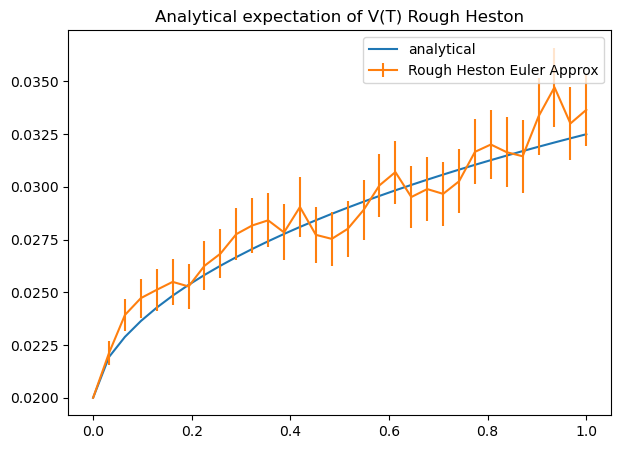

In [38]:
fig,ax = plt.subplots(1,1,figsize = (7,5))
ax.plot(timeArray, analyticalForwardVariance, label='analytical')
ax.set_title('Analytical expectation of V(T) Rough Heston')
ax.errorbar(timeArray, np.mean(volVector,axis = 1), yerr = np.std(volVector,axis = 1)/np.sqrt(NPaths),label = 'Rough Heston Euler Approx')
ax.legend()
